# Introduction to Variational Bayesian Methods
## David Schlueter
## Vanderbilt University Department of Biostatistics
### March 24, 2017

In Bayesian analysis, the most common strategy for computing posterior quantities is through Markov Chain Monte Carlo (MCMC). Despite recent advances in efficient sampling, MCMC methods still remain computationally intensive for more than a few thousand observations. A more scalable alternative to sampling is Variational Inference (VI), which re-frames the problem of computing the posterior distribution as a minimization of the Kullback-Leibler divergence between the true posterior and a member of some approximating family. 

In this talk, we provide a basic overview of the VI framework as well as practical examples of its implementation using the Automatic Differentiation Variational Inference (ADVI) engine in PyMC3. Notably, we'll generate a toy classification problem and walk through how to do it in PyMC3. 

## Basics of Variational Bayesian Methods 


For a more detailed overview, see [this paper](https://arxiv.org/abs/1601.00670).

Suppose we have data $\boldsymbol{x}$ that is dependent on some latent variables $\theta$. The inferential problem is to compute the conditional density of the latent variables given the 
observations, $p(\theta | x)$. From this probability we can compute all sorts of useful quantities. Conditional probability gives us 

\begin{equation}
p(\theta|x) = \frac{p(\theta,x)}{p(x)}
\end{equation}

Where 
\begin{equation}
p(x) = \int p(\theta,x) d\theta,
\end{equation}

Which is the log density of the data, often called the "model evidence."
- This quantity is often unavailable in closed form and is the main source of computational headache, hearbreak, and frustration. 

## So what can we do instead??
### Approximation to the posterior $p(\theta|X)$ using some other distribution $q(theta)$
#### What are some ways we can do this?


## How do we go about approximating a distribution with another?

### Let's see if we can approximate a student's t with a gaussian 
Let's approximate a Students-t distribution with $\nu =3$  with a Gaussian distribution of some mean and variance.


One naive approach would be to build a set of test points and minimize the MSE between the $\log p(z)$ and $\log q(z)$. NOTE THIS IS NOT A GOOD WAY TO DO THIS. AGAIN, DO NOT DO THIS IN REAL LIFE. 


$$
{\hat \phi} = \underset{\phi}{{\rm arg\,min}} \frac{\sum_{i} q(z_{i};\phi)\left[\log q(z_{i};\phi) - \log p(z_{i})\right]^{2}}{\sum_{i} q(z_{i};\phi)}
$$

In [19]:
# load our packages:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import time
import scipy.special
import scipy.optimize
import scipy.stats

%matplotlib inline 
sns.set()

In [ ]:
### Okay let's define some functions

In [20]:

ν = 3
ν_NORM = scipy.special.gammaln((ν + 1)/2) - scipy.special.gammaln(ν/2) - 0.5 * np.log(ν*np.pi)
def logp(z):
    """log of students-t dist."""
    return -0.5 * (ν+1) * np.log(1 + z*z/ν) + ν_NORM
    

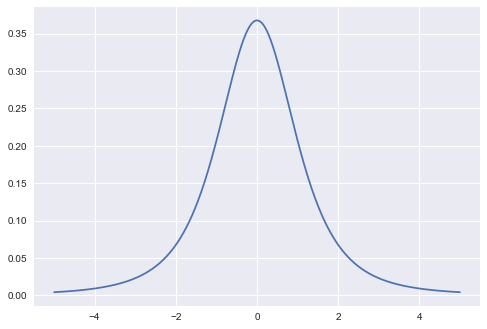

In [21]:
z = np.linspace(-5.0, 5.0, 1000)
pz = np.exp(logp(z))
plt.figure()
plt.plot(z, pz, label='p(z)')




## Let's define some functions to implement our routine for the approximation

In [22]:
### Approximating Distro
def logq(z, mu, lnsigma):
    """log of Gaussian parameterized by mean and log(sigma)"""
    sigma = np.exp(lnsigma)
    return -0.5 * ((z - mu) / sigma) ** 2 - lnsigma - 0.5*np.log(2.0 * np.pi)
## Objective function and fit using scipy optimizer
def regression_vi(logp, n, mu_start, lnsigma_start, atol=1e-6):
    """use an optimizer for simple 1D VI"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes sum above on a grid.
    def obj(phi):
        _sigma = np.exp(phi[1])  # get sigma
        
        # This is the grid, factor of 10 is a random choice.
        z = np.linspace(phi[0] - 10.0*_sigma , phi[0] + 10.0*_sigma, n)

        # Build weights and differences.
        logqz = logq(z, phi[0], phi[1])
        w = np.exp(logqz)
        diff = logqz - logp(z)
        return np.sum(diff * diff * w) / np.sum(w)

    # Run the optimizer.
    opts = {'disp': True, 'maxiter': 5000, 'maxfev': 5000,
            'fatol': atol, 'xatol': 1e-8}
    phi_hat = scipy.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options=opts)
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = regression_vi(logp, 100, 100.0, -100.0)

Optimization terminated successfully.
         Current function value: 0.034185
         Iterations: 107
         Function evaluations: 206
 final_simplex: (array([[ -3.31217268e-09,   1.39418201e-01],
       [  3.00982760e-09,   1.39418195e-01],
       [  5.89924420e-09,   1.39418199e-01]]), array([ 0.03418518,  0.03418518,  0.03418518]))
           fun: 0.03418517538400144
       message: 'Optimization terminated successfully.'
          nfev: 206
           nit: 107
        status: 0
       success: True
             x: array([ -3.31217268e-09,   1.39418201e-01])


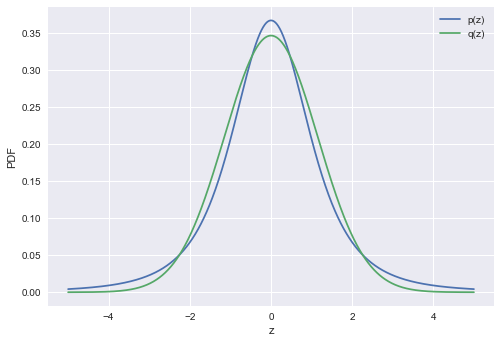

In [25]:
z = np.linspace(-5.0, 5.0, 1000)
pz = np.exp(logp(z))
qz = np.exp(logq(z, phi_hat[0], phi_hat[1]))

plt.figure()
plt.plot(z, pz, label='p(z)')
plt.plot(z, qz, label='q(z)')
plt.xlabel('z')
plt.ylabel('PDF')
plt.legend();

This looks okay, but is definitely unprinipled in it's approach. Notable, this won't work well in high dimensions. 

How about we use some sort of optimization in terms of of a criteria that involves full probability distributions?

# ENTER KL DIVERGENCE AND VARIATIONAL BAYES

As an alternative to sampling from an ergodic Markov Chain, Variational Bayes is an inferential method that approximates the posterior distribution through the minimization of the relative entropy (or in general some other operator). For an arbitrary posterior distribution $p(\theta|x)$, and some approximating family $q(z)$, the variational objective is defined by 

\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi}KL(q(\theta; \phi) || p(\theta|X))
\end{equation}


Now, we see that the KL divergence is given by
$$
D_{\rm KL}\big(Q||P\big) = \int q(z) \log\frac{q(z)}{p(z)}dz\ .
$$
\begin{eqnarray}
KL(q|p)&=&E_q\left[\log\frac{q(\theta)}{p(\theta|x)}\right]\\
&=&E_q[\log q(\theta)]-E_q[\log p(\theta|x)]\\
&=&-E_q[\log p(\theta,x)]+E_q[\log q(\theta)]+\log p(x). 
\end{eqnarray}

The quantity in the final line is known as the evidence lower bound (ELBO). To see why, let's consider the model evidence. 

\begin{eqnarray*}
\log p(x)&=&\log\int p(x,\theta)d\theta\\
&=&\log\int p(x,\theta)\frac{q(\theta)}{q(\theta)}d\theta\\
&=&\log(E_{q}\left[\frac{p(x,\theta)}{q(\theta)}\right])\\
&\geq& E_q[\log p(x,\theta)]-E_q[\log q(\theta)].
\end{eqnarray*}

We can see that the KL divergence is given by the sum of the ELBO and Model Evidence. What this implies for a computational solution is that minimizing the KL divergence is accomplished by maximizing the evidence lower bound.


In [26]:
def kl_vi(logp, n, mu_start, lnsigma_start):
    """vi with KL divergence"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes the KL div of q and p.
    def obj(phi):
        # This term is -\int q*log(q).
        # Also known as the differential entropy.
        # For a Gaussian, it can be computed exactly. 
        # See wikipedia or something.
        entropy = phi[1] + 0.5*np.log(2.0 * np.pi) + 0.5

        # This is the grid, factor of 20 is a random choice.
        _sigma = np.exp(phi[1])  # get sigma        
        z = np.linspace(phi[0] - 20.0*_sigma , phi[0] + 20.0*_sigma, n)
        dz = z[1] - z[0]  # factor needed for numerical integral
        
        # This term is \int q*log(p)
        logqz = logq(z, phi[0], phi[1])
        qz = np.exp(logqz)

        return -entropy - np.sum(qz * logp(z) * dz)

    # Run the optimizer.
    phi_hat = scipy.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options={'disp': True})
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = kl_vi(logp, 10000, 1.0, 0.0)

Optimization terminated successfully.
         Current function value: 0.040695
         Iterations: 56
         Function evaluations: 108
 final_simplex: (array([[ -4.26771590e-06,   2.31270951e-01],
       [  5.19733032e-05,   2.31261077e-01],
       [  5.67321110e-05,   2.31314504e-01]]), array([ 0.04069546,  0.04069546,  0.04069546]))
           fun: 0.040695455334933017
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 56
        status: 0
       success: True
             x: array([ -4.26771590e-06,   2.31270951e-01])


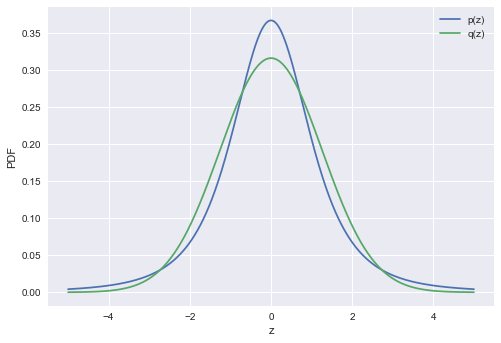

In [27]:
z = np.linspace(-5.0, 5.0, 1000)
pz = np.exp(logp(z))
qz = np.exp(logq(z, phi_hat[0], phi_hat[1]))

plt.figure()
plt.plot(z, pz, label='p(z)')
plt.plot(z, qz, label='q(z)')
plt.xlabel('z')
plt.ylabel('PDF')
plt.legend();


So, which variational family for z do we use? Most common is the \emph{mean-field} variational family where the latent variables are
mutually independent and each governed by a distinct factor in the variational density. A
generic member of the mean-field variational family is given by 

\begin{equation}
q(\theta) = \prod_{j=1}^m q_j(\theta_j)
\end{equation}

This is a restrictive approximation, but full rank alternatives are available. 



## Let's look at a more difficult pdf to approximate:
$$
\log p(z) = 10^{3}\log z + \log(1-z) - c
$$

In [13]:
def logq_unit(z, mu, lnsigma):
    """log of Gaussian parameterized by mean and log(sigma)
    has unit integral over 0,1 
    and value zero outside of 0,1
    """
    val = np.zeros_like(z)
    msk = (z >= 1.0) | (z <= 0.0)
    val[msk] = -np.inf
    if np.any(~msk):
        sigma = np.exp(lnsigma)
        a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
        val[~msk] = scipy.stats.truncnorm.logpdf(z[~msk], a=a, b=b, loc=mu, scale=sigma)
    
    return val

def logp_hard(z, a=1e3, b=1):
    val = np.zeros_like(z)
    msk = (z >= 1.0) | (z <= 0.0)
    val[msk] = -np.inf
    if np.any(~msk):
        val[~msk] = a * np.log(z) + b * np.log(1.0 - z) - scipy.special.betaln(a + 1.0, b + 1.0)
    return val

def kl_vi_unit(logp, n, mu_start, lnsigma_start, eps=1e-8):
    """vi with KL divergence over unit integral"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes the KL div of q and p.
    def obj(phi):
        # This term is -\int q*log(q).
        sigma = np.exp(phi[1])
        a, b = (0.0 - phi[0]) / sigma, (1.0 - phi[0]) / sigma
        entropy = scipy.stats.truncnorm.entropy(a=a, b=b, loc=phi[0], scale=sigma)

        # This is the grid, factor of 20 is a random choice.
        _sigma = np.exp(phi[1])  # get sigma        
        z = np.linspace(eps, 1.0 - eps, n)
        dz = z[1] - z[0]  # factor needed for numerical integral
        
        # This term is \int q*log(p)
        logqz = logq_unit(z, phi[0], phi[1])
        qz = np.exp(logqz)

        return -entropy - np.sum(qz * logp(z) * dz)

    # Run the optimizer.
    phi_hat = scipy.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options={'disp': True, 'maxfev': 10000})
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = kl_vi_unit(logp_hard, 10000, 0.0, 0.0)

/anaconda/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4846: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
/anaconda/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4850: RuntimeWarning: invalid value encountered in double_scalars
  return _norm_pdf(x) / self._delta


Optimization terminated successfully.
         Current function value: 0.145730
         Iterations: 231
         Function evaluations: 427
 final_simplex: (array([[ 0.9981397 , -6.63765288],
       [ 0.99813979, -6.63771762],
       [ 0.99813975, -6.63760831]]), array([ 0.14572997,  0.14572997,  0.14572997]))
           fun: 0.14572997442662317
       message: 'Optimization terminated successfully.'
          nfev: 427
           nit: 231
        status: 0
       success: True
             x: array([ 0.9981397 , -6.63765288])


<IPython.core.display.Javascript object>


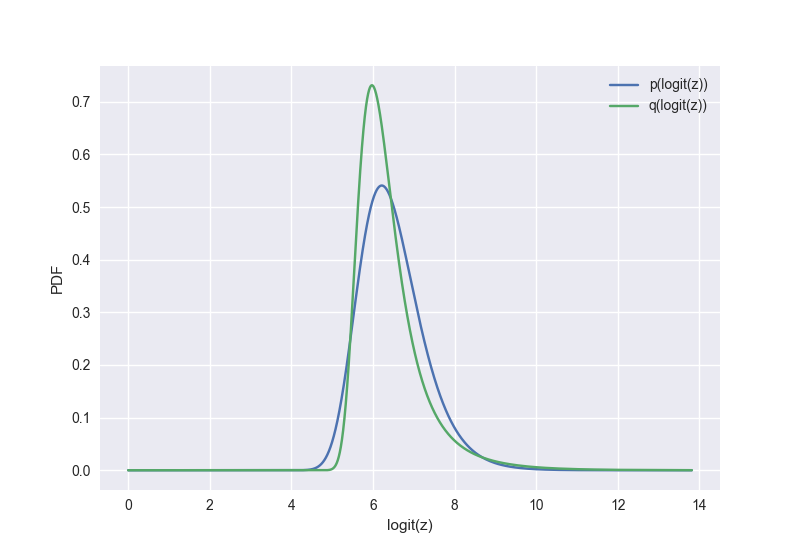

In [14]:
z = np.linspace(0.5, 0.999999, 100000)
pz = np.exp(logp_hard(z))
qz = np.exp(logq_unit(z, phi_hat[0], phi_hat[1]))
dz_dlogitz = z * (1.0 - z)

plt.figure()
plt.plot(scipy.special.logit(z), pz * dz_dlogitz, label='p(logit(z))')
plt.plot(scipy.special.logit(z), qz * dz_dlogitz, label='q(logit(z))')
plt.xlabel('logit(z)')
plt.ylabel('PDF')
plt.legend();

In [15]:
def logp_easy(logitz, a=1e3, b=1):
    logabsjac = -1.0 * (np.log(1.0 + np.exp(-logitz)) + np.log(1.0 + np.exp(logitz)))
    return (-a * np.log(1.0 + np.exp(-logitz)) - b * np.log(1.0 + np.exp(logitz)) + 
            logabsjac - 
            scipy.special.betaln(a + 1.0, b + 1.0))

phi_hat, res = kl_vi(logp_easy, 10000, 1.0, 0.0)

Optimization terminated successfully.
         Current function value: 0.041045
         Iterations: 65
         Function evaluations: 126
 final_simplex: (array([[ 6.46509387, -0.34497398],
       [ 6.46518205, -0.34488247],
       [ 6.46511969, -0.34501641]]), array([ 0.04104499,  0.04104499,  0.041045  ]))
           fun: 0.041044993988631262
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 65
        status: 0
       success: True
             x: array([ 6.46509387, -0.34497398])


In [16]:
def dlogp_easy_dx(x):
    z = scipy.special.expit(x)
    return (1e3 + 1.0) * (1.0 - z) - 2 * z

def kl_vi_with_sgd(dlogp, mu, lnsigma, rng, n_iter=100000, n_draw=1, eta=5e-4, eta_decay=5e-5):
    for i in range(n_iter):
        # Draw the points and convert back to draws from the variational approximation.
        x_standard = rng.normal(size=n_draw)
        sigma = np.exp(lnsigma)
        x = x_standard*sigma + mu
        
        # Compute the derivs.
        dkl_dmu = -np.mean(dlogp(x))
        dkl_dlnsigma = -np.mean(dlogp(x) * x_standard * sigma) - 1
        
        # Now do SGD with the KL divergence.
        lnsigma -= dkl_dlnsigma * eta
        mu -= dkl_dmu * eta
        
        # Decay the learning rate.
        eta *= 1.0 - eta_decay
        
        if i % (n_iter // 25) == 0 or i == n_iter - 1:
            print("iter, mu, lnsigma: % 7d|% 10.4e|% 10.4e" % 
                  (i, mu, lnsigma))
        
    return np.array([mu, lnsigma])

rng = np.random.RandomState(seed=5678)
phi_hat = kl_vi_with_sgd(dlogp_easy_dx, 0.0, 0.0, rng)

iter, mu, lnsigma:       0| 3.3518e-01|-2.3741e-01
iter, mu, lnsigma:    4000| 6.3373e+00|-4.7391e-01
iter, mu, lnsigma:    8000| 6.4378e+00|-3.4406e-01
iter, mu, lnsigma:   12000| 6.4592e+00|-3.5437e-01
iter, mu, lnsigma:   16000| 6.4571e+00|-3.4403e-01
iter, mu, lnsigma:   20000| 6.4656e+00|-3.5536e-01
iter, mu, lnsigma:   24000| 6.4663e+00|-3.6306e-01
iter, mu, lnsigma:   28000| 6.4572e+00|-3.5847e-01
iter, mu, lnsigma:   32000| 6.4657e+00|-3.5701e-01
iter, mu, lnsigma:   36000| 6.4643e+00|-3.5113e-01
iter, mu, lnsigma:   40000| 6.4556e+00|-3.4125e-01
iter, mu, lnsigma:   44000| 6.4647e+00|-3.4658e-01
iter, mu, lnsigma:   48000| 6.4712e+00|-3.4985e-01
iter, mu, lnsigma:   52000| 6.4660e+00|-3.4201e-01
iter, mu, lnsigma:   56000| 6.4645e+00|-3.4355e-01
iter, mu, lnsigma:   60000| 6.4649e+00|-3.4346e-01
iter, mu, lnsigma:   64000| 6.4657e+00|-3.4193e-01
iter, mu, lnsigma:   68000| 6.4624e+00|-3.4012e-01
iter, mu, lnsigma:   72000| 6.4602e+00|-3.3670e-01
iter, mu, lnsigma:   76000| 6.4

<IPython.core.display.Javascript object>


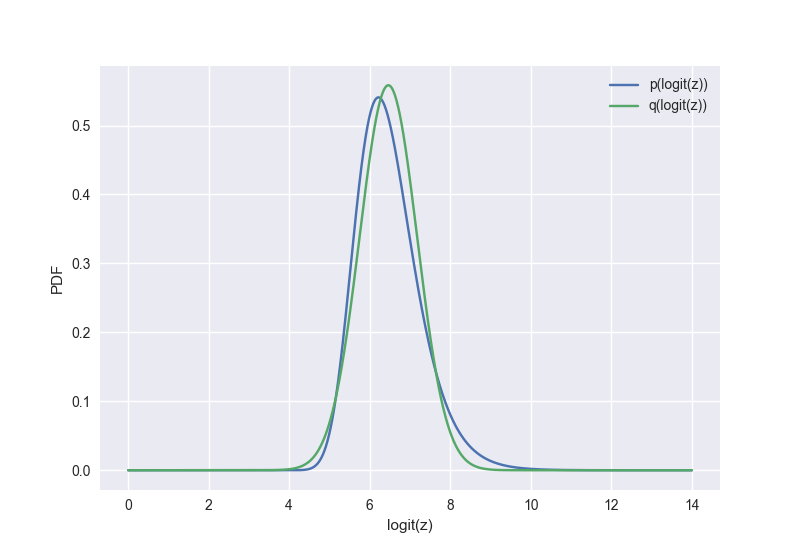

In [17]:
logitz = np.linspace(0.0, 14.0, 100000)
plogitz = np.exp(logp_easy(logitz))
qlogitz = np.exp(logq(logitz, phi_hat[0], phi_hat[1]))

plt.figure()
plt.plot(logitz, plogitz, label='p(logit(z))')
plt.plot(logitz, qlogitz, label='q(logit(z))')
plt.xlabel('logit(z)')
plt.ylabel('PDF')
plt.legend();


### [Automatic Differentiation Variational Inference](https://arxiv.org/abs/1603.00788)
With ease of computation in mind, Kucukelbir et. al. 2015 developed a way to perform VI automatically. Without going into too much detail (see reference for details), the authors proposed transforming the problem in a series of steps:

1. Specify the joint model, $p(x,\theta)$
2. Transform model into surrogate containing unconstrained real-valued latent variables, $\zeta$. $p(x,\theta) \to p(x,\zeta)$
    - Variational inference is then performed on the transformed model. New objective: 
    
$$
\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi} KL(q(\zeta; \phi)||p(\theta|\zeta))
\end{equation}
$$
    - all latent variables are defined on the same space. ADVI can now use a single variational family for all
     models
3. Recast the variational objective as an expectation over the the approximating distribution $q$ using the . 
3. ADVI recasts the gradient of the variational objective function as an expectation over q. This allows for the use of Monte Carlo integration to perform the optimization
4. Next, the framework transforms the problem again and re-casts the gradient in terms of a standard Gaussian distribution. This makes MC integration very efficient since sampling is done from $N(0,1)$
5. Compute noisy gradients to optimize the objective. 


## Variational Inference in PyMC3

Theano, PyTorch, and Tensorflow are all computational backends to compute derivatives symbolically so we don't have to hand code anything. PyMC3 uses Theano which is what we will be working in.






Let's try out ADVI on a simple robust regression task

In [81]:
# Now create toy data
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano

size = 50
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)




Okay let's plot this:

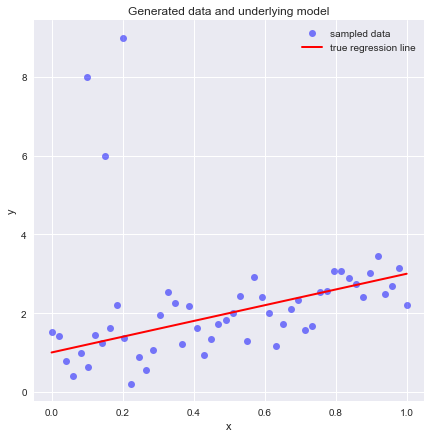

In [69]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
#plt.plot(x, y,"bo", label='sampled data', alpha =0.01)
ax.plot(x_out, y_out,"bo", label='sampled data',alpha =0.5)
ax.plot(x, true_regression_line, label='true regression line', lw=2.,color = "red")
plt.legend(loc=0);

In [78]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)

    # Inference!
    trace = pm.sample(3000, njobs=2) # draw 3000 posterior samples using NUTS sampling


100%|██████████| 3500/3500 [00:08<00:00, 435.86it/s]


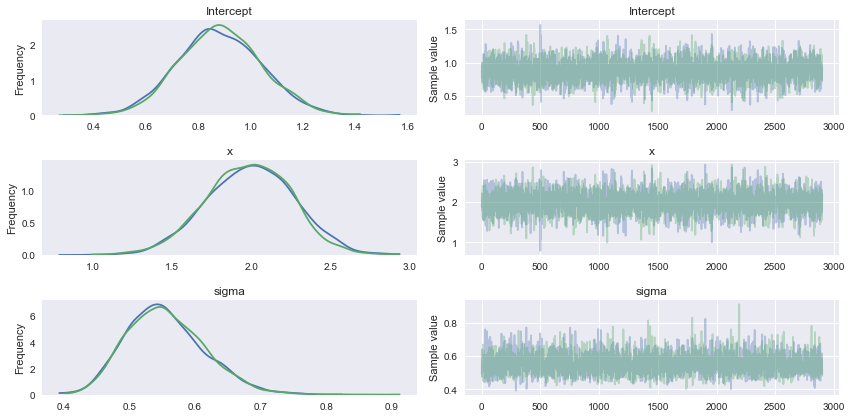

In [80]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

### Okay, cool now for the sake of demonstration, let's ramp up the number of observations and see how to perform minibatch ADVI in pymc3.

In [82]:
size = 500000
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

### First, we need to set up a framework where we minibatch the data:


In [90]:
batchsize =5000
x_minibatch = pm.Minibatch(x, batch_size=batchsize)
y_minibatch = pm.Minibatch(y, batch_size=batchsize)

### Don't worry, the indices are stored and shared across these minibatch tensors

### We now just need to make a few minor adjustments to our model in the likelihood portion

In [ ]:
with pm.Model() as model_vi: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    #define model mean in terms of minibatch tensor
    mean = intercept + x_coeff * x_minibatch
    # Define likelihood
    likelihood = pm.Normal('likelihood', mu =mean,
                        sd=sigma, observed=y_minibatch, total_size = len(y))
    # Inference!


In [ ]:
with model_vi:
    approx = pm.variational.fit(n=10000, method="fullrank_advi")

Average Loss = 6.0884e+05:  66%|██████▌   | 6552/10000 [00:37<00:20, 166.67it/s]

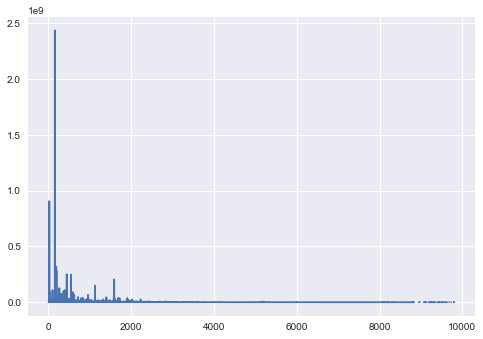

In [87]:
plt.plot(approx.hist)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bdc2080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12c5147f0>]], dtype=object)

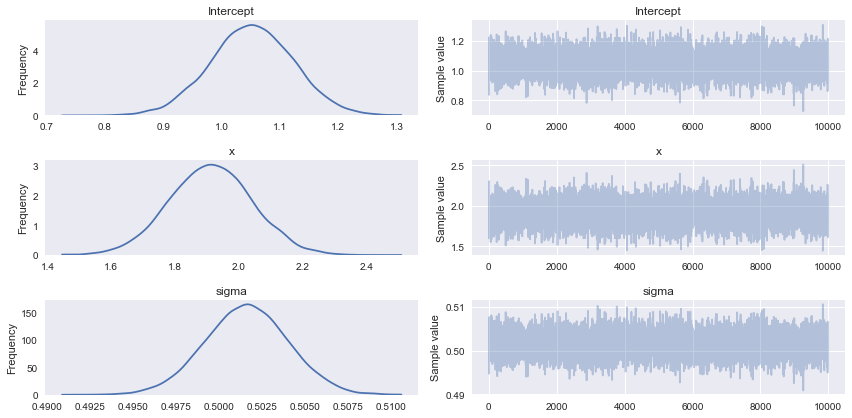

In [89]:
trace_vi = approx.sample(10000)
pm.traceplot(trace_vi)

# The future: Normalizing Flows VI.

### Example: Bayesian Neural Network

For an in depth introduction to Neural Networks, see Chris Fonnesbeck's notebook [here](https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section6_7-Neural-Networks.ipynb)

In [ ]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [ ]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

We first define the model. Since, PyMC3 uses Theano as a back end, functions need to be compiled first. 

In [ ]:
# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                             shape=(X.shape[1], n_hidden),
                             testval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                              shape=(n_hidden,),
                              testval=init_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                     weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1,
                                     weights_1_2))
    act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                          weights_2_out))

    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out',
                       act_out,
                       observed=ann_output)

Now we run the ADVI routine.

In [ ]:
%%time
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Once the optimization has been performed, we simply sample from the approximating distribution.

In [ ]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

We can see the optimization course by plotting the ELBO values over time.

In [ ]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

Of course, we can predict new values...

In [ ]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))


In [ ]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)


In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

### Mini-Batch ADVI

- Instead of using the full dataset at once, we can visit subsamples of the data of size $B<<N$. This reduces complexity of the algorithm to a per-iteration complexity $O(2BMK)$.
- Mini-batch is considered best practice
     - Helps protect against getting stuck in local minima
     - Faster convergence 
- Set up in PyMC is relatively straightforward.
    1. Define Tensors for data
    2. Specify PyMC3 model in terms of these tensors
    3. Create generator for sampling of data
    4. Run ADVI-Minibatch function

In [ ]:
from six.moves import zip

# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)

    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train),
    create_minibatch(Y_train),
)

total_size = len(Y_train)

In [ ]:
%%time
with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors,
        minibatch_RVs=minibatch_RVs, minibatches=minibatches,
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

In [ ]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

In [ ]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')
sns.despine()

In [ ]:
pm.traceplot(trace);


### References: 
    1. [Automatic Differentiation Variational Inference. Kucukelbir, A., Tran D., Ranganath, R., Gelman, A., and Blei, D. M. (2016)](https://arxiv.org/abs/1603.00788)
    2. [Variational Inference: A Review for Statisticians, David M. Blei, Alp Kucukelbir, Jon D. McAuliffe (2016)] (https://arxiv.org/abs/1601.00670)